<a href="https://colab.research.google.com/github/imshivs/hummingbirds/blob/main/hummingbirds_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Effects of Climate Change on Hummingbird Habitat**

#### Kriti Saxena (krsaxena@calpoly.edu)

#### Shivani Negi (shnegi@calpoly.edu)

Link to Colab: https://colab.research.google.com/drive/1HhgGpYOb0hVTGMg9ewVkh9lcBR6zkXDY?usp=sharing

By 2080, Allen's hummingbird (population: 1500000) is expected to lose 90 percent of its current breeding range, according to Audubon’s climate models. Our hypothesis is that over the last 10 years, allen's hummingbird has been moving to higher elevations as a result of global warming. Anna's hummingbird (population: 9600000), another common species on the West Coast, can already be discovered at elevations ranging from 10-2,800 meters (33-9,186 feet). Allen's Hummingbirds, on the other hand, tend to live in a narrow strip of coastal forest, scrub, and chaparral from sea level to around 1,000 feet elevation along the West Coast. Due to climate change, Allen's hummingbird may be forced to find more suitable habitat, as well.

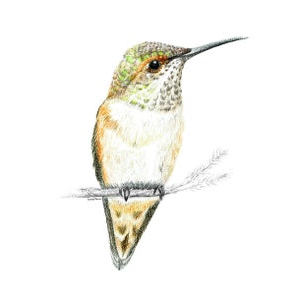



In [87]:
import pandas as pd
import numpy as np 
import geopy as gp
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import warnings
import sqlite3
from pathlib import Path as Path
from collections import Counter
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Extraction & Cleaning

Ebird exported observations for Allen hummingbirds filtered for last 10 years within 8 counties in Southern California (Los Angeles, Orange, Ventura, Santa Barbara, Kern, San Bernardino, Riverside, San Diego)

Found top counties based on number of observations in three regions

So CA Top Counties: Los Angeles, Orange, San Diego, Ventura, Santa Barbara

Nor CA Top Counties: San Francisco, San Mateo, Marin, Humboldt, Alameda

OR Top Counties: Coos, Curry

Imported weather data 2013 and 2022 for all counties

In [88]:
from pathlib import Path as Path
import sqlite3
data = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all_ebd_hummingbirds.csv"))

Path('bird.db').touch()
data_bird_conn = sqlite3.connect('bird.db')
data_bird_cursor = data_bird_conn.cursor()
data.to_sql('all_ebd_hummingbirds.csv', data_bird_conn, if_exists='append', index=False)

In [89]:
oregon_10 = pd.read_sql('''SELECT state, county, SUM(observation_count) AS Count FROM 'all_ebd_hummingbirds.csv'
                                WHERE state == 'Oregon'
                                GROUP BY county 
                                ORDER BY Count DESC
                                LIMIT 10''', data_bird_conn)
oregon_10

,state,county,Count
0,Oregon,Curry,612.0
1,Oregon,Coos,18.0


In [90]:
north_cal_top = pd.read_sql('''SELECT state, county, SUM(observation_count) AS Count FROM 'all_ebd_hummingbirds.csv'
                                WHERE state = 'California' AND latitude > 37.00
                                GROUP BY county 
                                ORDER BY Count DESC
                                LIMIT 5''', data_bird_conn)
north_cal_top

,state,county,Count
0,California,San Francisco,115044.0
1,California,San Mateo,45891.0
2,California,Marin,45801.0
3,California,Humboldt,33621.0
4,California,Alameda,21552.0


In [91]:
south_cal_top = pd.read_sql('''SELECT state, county, SUM(observation_count) AS Count FROM 'all_ebd_hummingbirds.csv'
                                WHERE state = 'California' AND latitude < 37.00
                                GROUP BY county 
                                ORDER BY Count DESC
                                LIMIT 5''', data_bird_conn)
south_cal_top

,state,county,Count
0,California,Los Angeles,1303443.0
1,California,Orange,848349.0
2,California,San Diego,463890.0
3,California,Ventura,163029.0
4,California,Santa Barbara,79854.0


Remove rows with Xs in observation count column from data set and convert data types where necessary for calculations. Filter observations for 12 counties and years 2013 or 2022 only.

In [92]:
data = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all_ebd_hummingbirds.csv"))
data["observation_date"] = pd.to_datetime(data["observation_date"])
data["year"] = data["observation_date"].dt.year
#observations = data[(data["year"] == 2013) | (data["year"] == 2022)]
#observations[["global_unique_identifier","observation_count","latitude","longitude","observation_date","common_name","scientific_name"]]

In [93]:
data["observation_date"] = pd.to_datetime(data['observation_date'])
data["month"] = data["observation_date"].dt.month
data["year"] = data["observation_date"].dt.year
data["observation_count"] = data["observation_count"].str.replace('X','')
data["observation_count"] = pd.to_numeric(data["observation_count"])
data["latitude"] = pd.to_numeric(data["latitude"])
data["longitude"] = pd.to_numeric(data["longitude"])
data = data[data["observation_count"].notna()]
data = data[data["latitude"].notna()]
data = data[data["longitude"].notna()]
data = data[~(data['year'] == 2023)]

## **Migratory Pattern - California and Oregon**

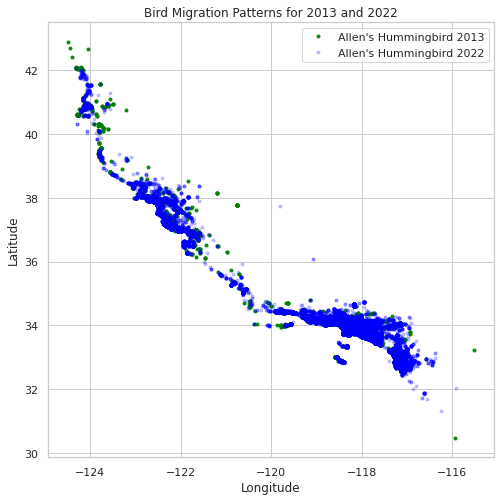

In [94]:
plt.figure(figsize=(8, 8))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Bird Migration Patterns for {year1} and {year2}")

x1, y1 = data.longitude[(data.year == 2013)& (data.state.str.contains("California|Oregon"))], data.latitude[(data.year == 2013) & (data.state.str.contains("California|Oregon"))]
x2, y2 = data.longitude[(data.year == 2022) & (data.state.str.contains("California|Oregon"))], data.latitude[(data.year == 2022) & (data.state.str.contains("California|Oregon"))]
plt.plot(x1, y1, ".", label="Allen's Hummingbird 2013", alpha=0.90, color="green")
plt.plot(x2, y2, ".", label="Allen's Hummingbird 2022", alpha=0.20, color="blue")

plt.legend(loc="best")
plt.show()


## **Count of bird observations in each county**

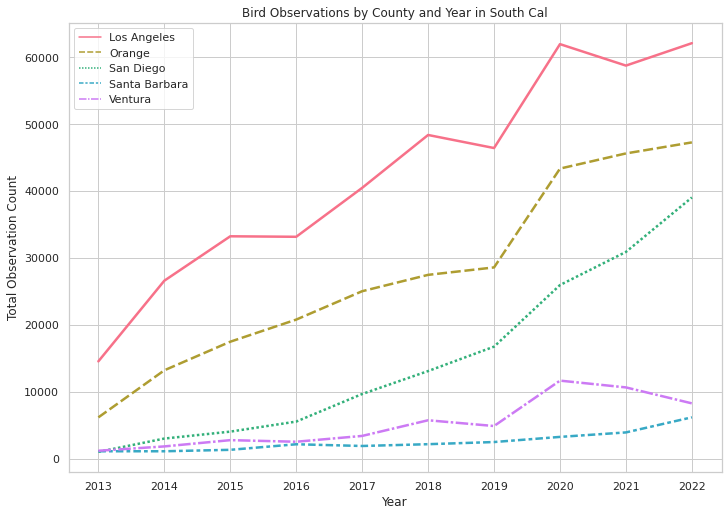

In [95]:
filter_south_cal = ['Los Angeles', 'Orange', 'San Diego', 'Ventura', 'Santa Barbara']
birddata = data[data.county.isin(filter_south_cal)]

counts_by_county_year = birddata.groupby(["county", "year"]).observation_count.sum()

counts_by_county = counts_by_county_year.unstack(level=0)

sns.lineplot(data=counts_by_county, palette="husl", linewidth=2.5)
plt.xlabel("Year")
plt.ylabel("Total Observation Count")
plt.title("Bird Observations by County and Year in South Cal")
plt.legend(loc="upper left")
plt.xticks([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
plt.show()

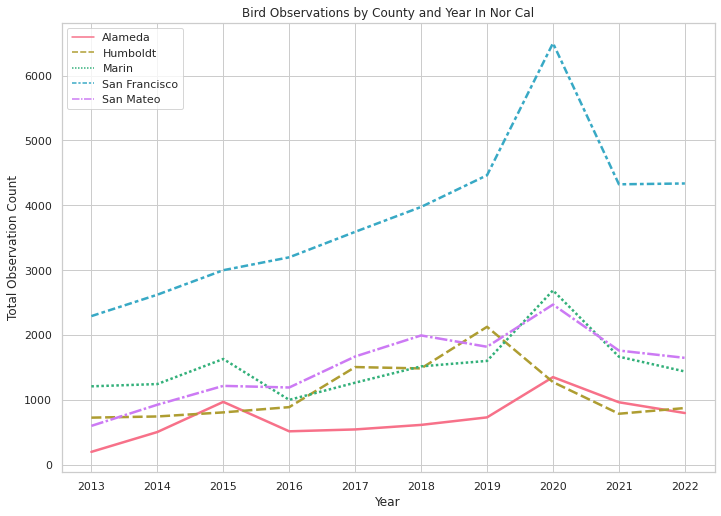

In [96]:
filter_north_cal = ['San Francisco', 'San Mateo', 'Marin', 'Humboldt', 'Alameda']
bird_data = data[data.county.isin(filter_north_cal)]

counts_by_county_year = bird_data.groupby(["county", "year"]).observation_count.sum()

counts_by_county = counts_by_county_year.unstack(level=0)

sns.lineplot(data=counts_by_county, palette="husl", linewidth=2.5)
plt.xlabel("Year")
plt.ylabel("Total Observation Count")
plt.title("Bird Observations by County and Year In Nor Cal")
plt.legend(loc="upper left")
plt.xticks([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
plt.show()

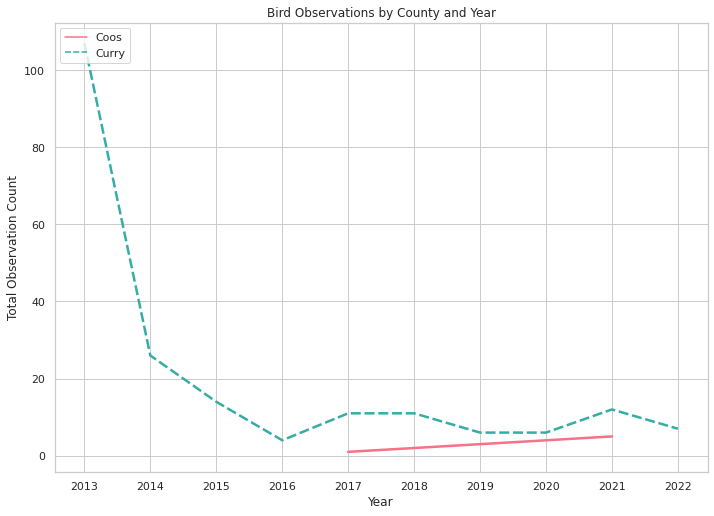

In [97]:
filter_oregon = ['Curry', 'Coos']
bird_data = data[data.county.isin(filter_oregon)]

counts_by_county_year = bird_data.groupby(["county", "year"]).observation_count.sum()

counts_by_county = counts_by_county_year.unstack(level=0)

sns.lineplot(data=counts_by_county, palette='husl', linewidth=2.5)
plt.xlabel("Year")
plt.ylabel("Total Observation Count")
plt.title("Bird Observations by County and Year")
plt.legend(loc="upper left")
plt.xticks([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
plt.show()

**Import Temperature Data**

In [98]:
losangeles_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/los_angeles_temp_2013.csv')).dropna()
orange_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/orange_2013.csv')).dropna()
sandiego_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/sandiego_2013.csv')).dropna()
ventura_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/ventura_2013.csv')).dropna()
santabarbara_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/santabarbara_2013.csv')).dropna()
sanfrancisco_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/sanfrancisco_2013.csv')).dropna()
sanmateo_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/sanmateo_2013.csv')).dropna()
marin_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/marin_2013.csv')).dropna()
humboldt_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/humboldt_2013.csv')).dropna()
alameda_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/alameda_2013.csv')).dropna()
coos_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/coos_2013.csv')).dropna()
curry_temp1 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/curry_2013.csv')).dropna()

losangeles_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/losangeles_2022.csv')).dropna()
orange_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/orange_2022.csv')).dropna()
sandiego_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/sandiego_2022.csv')).dropna()
ventura_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/ventura_2022.csv')).dropna()
santabarbara_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/santabarbara_2022.csv')).dropna()
sanfrancisco_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/sanfrancisco_2022.csv')).dropna()
sanmateo_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/sanmateo_2022.csv')).dropna()
marin_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/marin_2022.csv')).dropna()
humboldt_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/humboldt_2022.csv')).dropna()
alameda_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/alameda_2022.csv')).dropna()
coos_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/coos_2022.csv')).dropna()
curry_temp2 = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/curry_2022.csv')).dropna()


In [99]:
all_temps = losangeles_temp1.append(orange_temp1)
all_temps = all_temps.append(sandiego_temp1)
all_temps = all_temps.append(ventura_temp1)
all_temps = all_temps.append(santabarbara_temp1)
all_temps = all_temps.append(sanfrancisco_temp1)
all_temps = all_temps.append(sanmateo_temp1)
all_temps = all_temps.append(marin_temp1)
all_temps = all_temps.append(humboldt_temp1)
all_temps = all_temps.append(alameda_temp1)
all_temps = all_temps.append(coos_temp1)
all_temps = all_temps.append(curry_temp1)

all_temps = all_temps.append(losangeles_temp2)
all_temps = all_temps.append(orange_temp2)
all_temps = all_temps.append(sandiego_temp2)
all_temps = all_temps.append(ventura_temp2)
all_temps = all_temps.append(santabarbara_temp2)
all_temps = all_temps.append(sanfrancisco_temp2)
all_temps = all_temps.append(sanmateo_temp2)
all_temps = all_temps.append(marin_temp2)
all_temps = all_temps.append(humboldt_temp2)
all_temps = all_temps.append(alameda_temp2)
all_temps = all_temps.append(coos_temp2)
all_temps = all_temps.append(curry_temp2)

**Distance Calculation**

In [100]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [101]:
observation_temps = pd.DataFrame(np.empty(0, dtype=[('global_unique_identifier', 'S20'), ('tavg', 'f8')]))
distances = pd.DataFrame()

all_temps["TAVG"] = pd.to_numeric(all_temps["TAVG"])
all_temps["LONGITUDE"] = pd.to_numeric(all_temps["LONGITUDE"])
all_temps["LATITUDE"] = pd.to_numeric(all_temps["LATITUDE"])
all_temps["DATE"] = pd.to_datetime(all_temps['DATE'])
all_temps = all_temps.dropna()

In [102]:
observations = data[data["county"].str.contains("Los Angeles|Orange|San Diego|Ventura|Santa Barbara|San Francisco|San Mateo|Marin|Humboldt|Alameda|Coos|Curry") & (data["year"] == 2013) | (data["year"] == 2022)]
temp_df = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/observation_temps.csv'))

if not temp_df.empty:
  observation_temps = temp_df.dropna()
  observation_temps = observation_temps[~observation_temps["tavg"].str.endswith("float64")]
else:
  for index, row in observations.iterrows():
      # calculate haversine distance between current row and each row in la_temp dataframe
      temp_dates_subset = all_temps[all_temps["DATE"]==row["observation_date"]]
      distances = temp_dates_subset.apply(lambda x: haversine(row['longitude'], row['latitude'], x['LONGITUDE'], x['LATITUDE']),axis=1)
      # find index of closest row
      if not distances.empty:
        closest_index = distances.idxmin()
        #append observation identifier and temperature to closest_matches dataframe
        observation_temps = observation_temps.append({'global_unique_identifier': row['global_unique_identifier'], 'tavg': temp_dates_subset.loc[closest_index, 'TAVG']}, ignore_index=True)   
      else:
        continue
  observation_temps.dropna()

  observation_temps.to_csv('/content/drive/My Drive/Colab Notebooks/observation_temps.csv', index = False, header=True)



In [103]:
observations_with_temps = observation_temps.merge(observations, left_on='global_unique_identifier', right_on='global_unique_identifier')
observations_with_temps[["global_unique_identifier","tavg","latitude","longitude","month","observation_date","county"]]

,global_unique_identifier,tavg,latitude,longitude,month,observation_date,county
0,URN:CornellLabOfOrnithology:EBIRD:OBS331656714,21.2,34.423208,-119.889801,9,2013-09-29,Santa Barbara
1,URN:CornellLabOfOrnithology:EBIRD:OBS209579646,25.1,33.667204,-117.838347,9,2013-09-01,Orange
2,URN:CornellLabOfOrnithology:EBIRD:OBS202800376,26.5,34.032176,-118.071270,6,2013-06-28,Los Angeles
3,URN:CornellLabOfOrnithology:EBIRD:OBS204275312,23.1,34.266753,-119.196905,7,2013-07-10,Ventura
4,URN:CornellLabOfOrnithology:EBIRD:OBS210229884,26.6,33.653638,-117.785883,9,2013-09-08,Orange
...,...,...,...,...,...,...,...
69810,URN:CornellLabOfOrnithology:EBIRD:OBS1424923032,20.0,33.685258,-117.662306,5,2022-05-12,Orange
69811,URN:CornellLabOfOrnithology:EBIRD:OBS1461412036,15.4,34.206804,-118.124832,6,2022-06-17,Los Angeles
69812,URN:CornellLabOfOrnithology:EBIRD:OBS1451258898,14.6,34.056108,-118.512354,6,2022-06-04,Los Angeles
69813,URN:CornellLabOfOrnithology:EBIRD:OBS1528658101,24.2,33.118948,-117.236918,9,2022-09-29,San Diego


**Average Temperature of Hummingbird Observations**

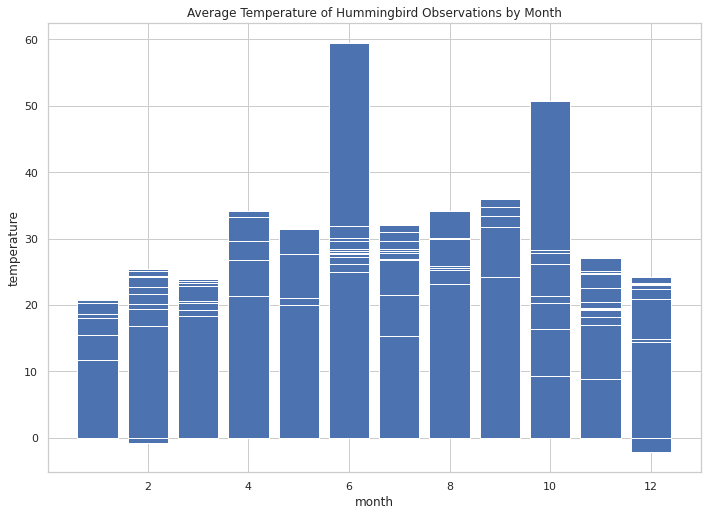

In [86]:
observations_with_temps['tavg'] = pd.to_numeric(observations_with_temps['tavg'])
plt.bar(observations_with_temps['month'],observations_with_temps['tavg'])
plt.title('Average Temperature of Hummingbird Observations by Month')
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

(array([2.6800e+02, 3.6730e+03, 2.8398e+04, 2.6421e+04, 1.0040e+04,
        1.0100e+03, 2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-2.1 ,  4.05, 10.2 , 16.35, 22.5 , 28.65, 34.8 , 40.95, 47.1 ,
        53.25, 59.4 ]),
 <BarContainer object of 10 artists>)

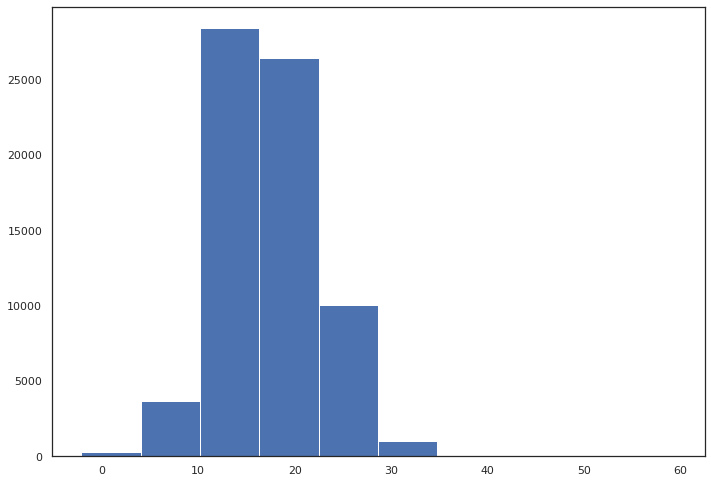

In [114]:
observations_with_temps['tavg'] = pd.to_numeric(observations_with_temps['tavg'])
plt.hist(observations_with_temps['tavg'])

Text(0.5, 1.0, '2013 Density Plot of Hummingbird Habitat Temperature by Region')

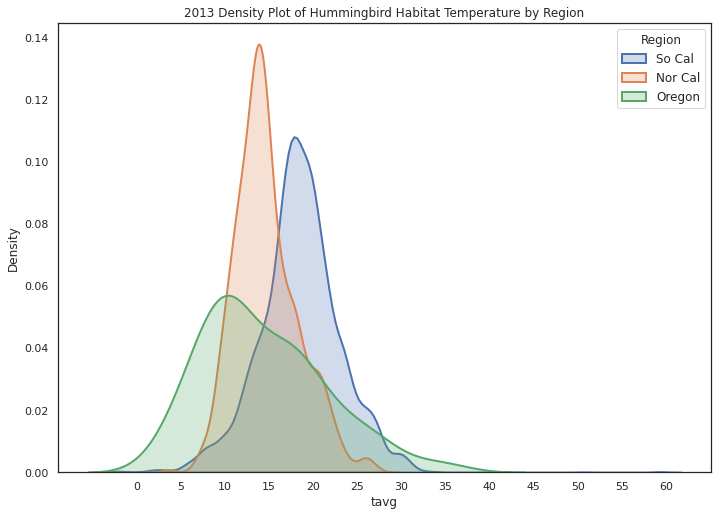

In [105]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

so_cal = observations_with_temps[observations_with_temps['county'].str.contains("Los Angeles|Orange|San Diego|Ventura|Santa Barbara") & (observations_with_temps['year'] == 2013)]
nor_cal = observations_with_temps[observations_with_temps['county'].str.contains("San Francisco|San Mateo|Marin|Humboldt|Alameda") & (observations_with_temps['year'] == 2013)]
oregon = observations_with_temps[observations_with_temps['county'].str.contains("Coos|Curry") & (observations_with_temps['year'] == 2013)]


sns.distplot(so_cal['tavg'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2},label = "So Cal")
sns.distplot(nor_cal['tavg'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2},label = "Nor Cal")
sns.distplot(oregon['tavg'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2},label = "Oregon")
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Region')
plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.title('2013 Density Plot of Hummingbird Habitat Temperature by Region')

Text(0.5, 1.0, '2022 Density Plot of Hummingbird Habitat Temperature by Region')

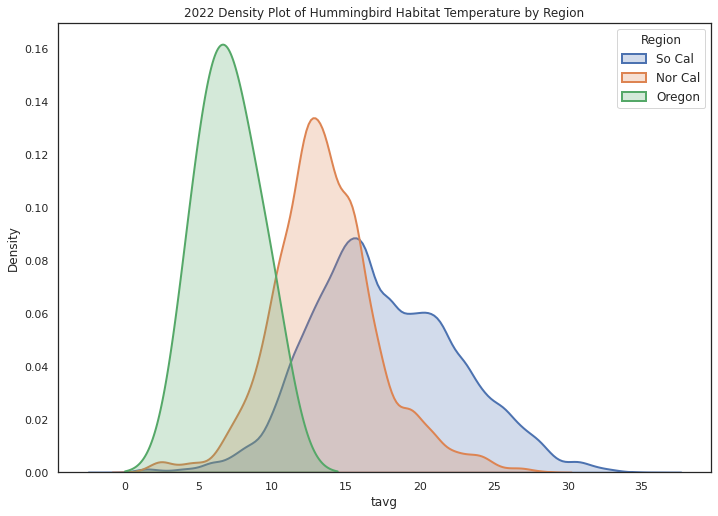

In [106]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

so_cal = observations_with_temps[observations_with_temps['county'].str.contains("Los Angeles|Orange|San Diego|Ventura|Santa Barbara") & (observations_with_temps['year'] == 2022)]
nor_cal = observations_with_temps[observations_with_temps['county'].str.contains("San Francisco|San Mateo|Marin|Humboldt|Alameda") & (observations_with_temps['year'] == 2022)]
oregon = observations_with_temps[observations_with_temps['county'].str.contains("Coos|Curry") & (observations_with_temps['year'] == 2022)]


sns.distplot(so_cal['tavg'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2},label = "So Cal")
sns.distplot(nor_cal['tavg'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2},label = "Nor Cal")
sns.distplot(oregon['tavg'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2},label = "Oregon")
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Region')
plt.title('2022 Density Plot of Hummingbird Habitat Temperature by Region')

# Months of Residence in Oregon, Northern California, and Southern CA

In [107]:
so_cal = observations_with_temps[observations_with_temps['county'].str.contains("Los Angeles|Orange|San Diego|Ventura|Santa Barbara") & (observations_with_temps['year'] == 2013)]
nor_cal = observations_with_temps[observations_with_temps['county'].str.contains("San Francisco|San Mateo|Marin|Humboldt|Alameda") & (observations_with_temps['year'] == 2013)]
oregon = observations_with_temps[observations_with_temps['county'].str.contains("Coos|Curry") & (observations_with_temps['year'] == 2013)]

so_cal = so_cal[["observation_count","month", "year"]]
so_cal["region"] = "Southern CA"
nor_cal = nor_cal[["observation_count","month", "year"]]
nor_cal["region"] = "Northern CA"
oregon = oregon[["observation_count","month", "year"]]
oregon["region"] = "Oregon"


nor_cal_groups = nor_cal.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
nor_cal_groups

so_cal_groups = so_cal.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
so_cal_groups

oregon_groups = oregon.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
so_cal_groups

oregon_groups = oregon.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
oregon_groups

so_cal_groups = so_cal_groups.pivot_table(columns=['region','month','year'], values=['observation_count'] )
nor_cal_groups = nor_cal_groups.pivot_table(columns=['region','month','year'], values=['observation_count'] )
oregon_groups = oregon_groups.pivot_table(columns=['region','month','year'], values=['observation_count'] )

display(so_cal_groups)
display(nor_cal_groups)
display(oregon_groups)

##################

so_cal = observations_with_temps[observations_with_temps['county'].str.contains("Los Angeles|Orange|San Diego|Ventura|Santa Barbara") & (observations_with_temps['year'] == 2022)]
nor_cal = observations_with_temps[observations_with_temps['county'].str.contains("San Francisco|San Mateo|Marin|Humboldt|Alameda") & (observations_with_temps['year'] == 2022)]
oregon = observations_with_temps[observations_with_temps['county'].str.contains("Coos|Curry") & (observations_with_temps['year'] == 2022)]

so_cal = so_cal[["observation_count","month", "year"]]
so_cal["region"] = "Southern CA"
nor_cal = nor_cal[["observation_count","month", "year"]]
nor_cal["region"] = "Northern CA"
oregon = oregon[["observation_count","month", "year"]]
oregon["region"] = "Oregon"


nor_cal_groups = nor_cal.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
nor_cal_groups

so_cal_groups = so_cal.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
so_cal_groups

oregon_groups = oregon.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
so_cal_groups

oregon_groups = oregon.groupby(["month","year"]).agg(observation_count =('observation_count','sum'),region = ('region','max'))
oregon_groups

so_cal_groups = so_cal_groups.pivot_table(columns=['region','month','year'], values=['observation_count'] )
nor_cal_groups = nor_cal_groups.pivot_table(columns=['region','month','year'], values=['observation_count'] )
oregon_groups = oregon_groups.pivot_table(columns=['region','month','year'], values=['observation_count'] )

display(so_cal_groups)
display(nor_cal_groups)
display(oregon_groups)


region            Southern CA                                                  \
month                      4       5       6       7       8       9       10   
year                     2013    2013    2013    2013    2013    2013    2013   
observation_count      3263.0  3359.0  2233.0  2101.0  1749.0  2372.0  2496.0   

region                             
month                  11      12  
year                 2013    2013  
observation_count  2574.0  4022.0

region            Northern CA                       
month                       4       5       6      7
year                     2013    2013    2013   2013
observation_count      1663.0  1542.0  1451.0  363.0

region            Oregon                  
month                  4     5     6     7
year                2013  2013  2013  2013
observation_count   26.0  39.0  26.0  16.0

region            Southern CA                                              \
month                      1        2        3        4        5       6    
year                     2022     2022     2022     2022     2022    2022   
observation_count     17551.0  13808.0  12780.0  17321.0  16365.0  9717.0   

region                                                                  
month                   7        8        9        10      11       12  
year                  2022     2022     2022     2022    2022     2022  
observation_count  11130.0  11382.0  12880.0  13680.0  9841.0  16411.0

region            Northern CA                                                \
month                       1      2       3       4       5       6      7   
year                     2022   2022    2022    2022    2022    2022   2022   
observation_count        73.0  809.0  1562.0  2203.0  2180.0  1426.0  735.0   

region                        
month                 8    9  
year               2022 2022  
observation_count  26.0  1.0

region            Oregon     
month                  4    5
year                2022 2022
observation_count    6.0  1.0